# HOUSING DATASET MODEL TRAINING
GOAL: Predict the median housing price per district. Price is in $ (US Dollars.)

### Assumptions
1. `Median income` is a very important field in the dataset.
    * The values in this field are scaled to $10,000, i.e, 1 = $10,000 dollars.
    

In [1]:
import os
import tarfile
from six.moves import urllib

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Data cleaning
from sklearn.impute import SimpleImputer

# Data preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Linear Regression
from sklearn.linear_model import LinearRegression

# import other regression algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Cross-validation
from sklearn.model_selection import cross_val_score

#grid search
from sklearn.model_selection  import GridSearchCV


#metrics 
from sklearn.metrics import mean_squared_error

# saving the model.
import joblib

'''If you are running this notebook for the first time and you do not have the data, please uncomment the function and function call to download and save the data.'''

# DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# HOUSING_PATH = os.path.join('datasets', 'housing')
# HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
# 
# def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
#     if not os.path.isdir(housing_path):
#         os.makedirs(housing_path)
#     tgz_path = os.path.join(housing_path, 'housing.tgz')
#     urllib.request.urlretrieve(housing_url, tgz_path)
#     housing_tgz = tarfile.open(tgz_path)
#     housing_tgz.extractall(path=housing_path)
#     housing_tgz.close()

#fetch_housing_data() # comment this after running the code for the first time... the data has been saved in a working directory

KeyboardInterrupt: 

# Load the data

In [2]:
'''If you are running the code for the first time, please uncomment the function and function call.'''
# # load the data
# def load_housing_data (housing_path = HOUSING_PATH):
#     csv_path = os.path.join(housing_path,'housing.csv')
#     return pd.read_csv(csv_path)

# housing = load_housing_data() # comment this after running your code for the first time.
housing = pd.read_csv('datasets/housing/housing.csv') # uncomment this line after running the code for the first time.
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Inspect the data

In [3]:
print(f"The data has {housing.shape[0]} rows and {housing.shape[1]} columns")

The data has 20640 rows and 10 columns


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
longitude,20640.0,NaN,NaN,NaN,-119.569704,2.003532,-124.35,-121.8,-118.49,-118.01,-114.31
latitude,20640.0,NaN,NaN,NaN,35.631861,2.135952,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640.0,NaN,NaN,NaN,28.639486,12.585558,1.0,18.0,29.0,37.0,52.0
total_rooms,20640.0,NaN,NaN,NaN,2635.763081,2181.615252,2.0,1447.75,2127.0,3148.0,39320.0
total_bedrooms,20433.0,NaN,NaN,NaN,537.870553,421.38507,1.0,296.0,435.0,647.0,6445.0
population,20640.0,NaN,NaN,NaN,1425.476744,1132.462122,3.0,787.0,1166.0,1725.0,35682.0
households,20640.0,NaN,NaN,NaN,499.53968,382.329753,1.0,280.0,409.0,605.0,6082.0
median_income,20640.0,NaN,NaN,NaN,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,NaN,NaN,NaN,206855.816909,115395.615874,14999.0,119600.0,179700.0,264725.0,500001.0
ocean_proximity,20640,5,<1H OCEAN,9136,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`total_bedrooms` column has some missing values.

<Axes: xlabel='ocean_proximity', ylabel='count'>

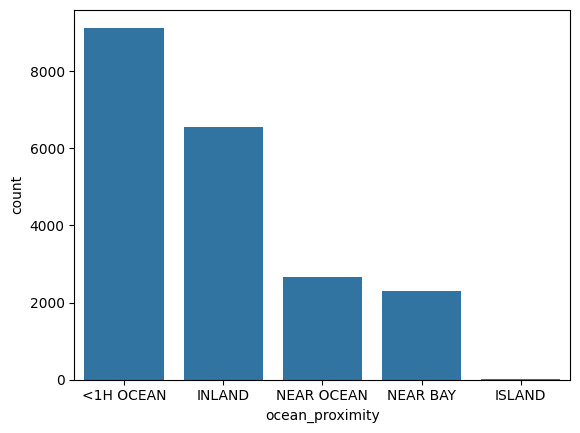

In [6]:
sns.barplot(housing['ocean_proximity'].value_counts())

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

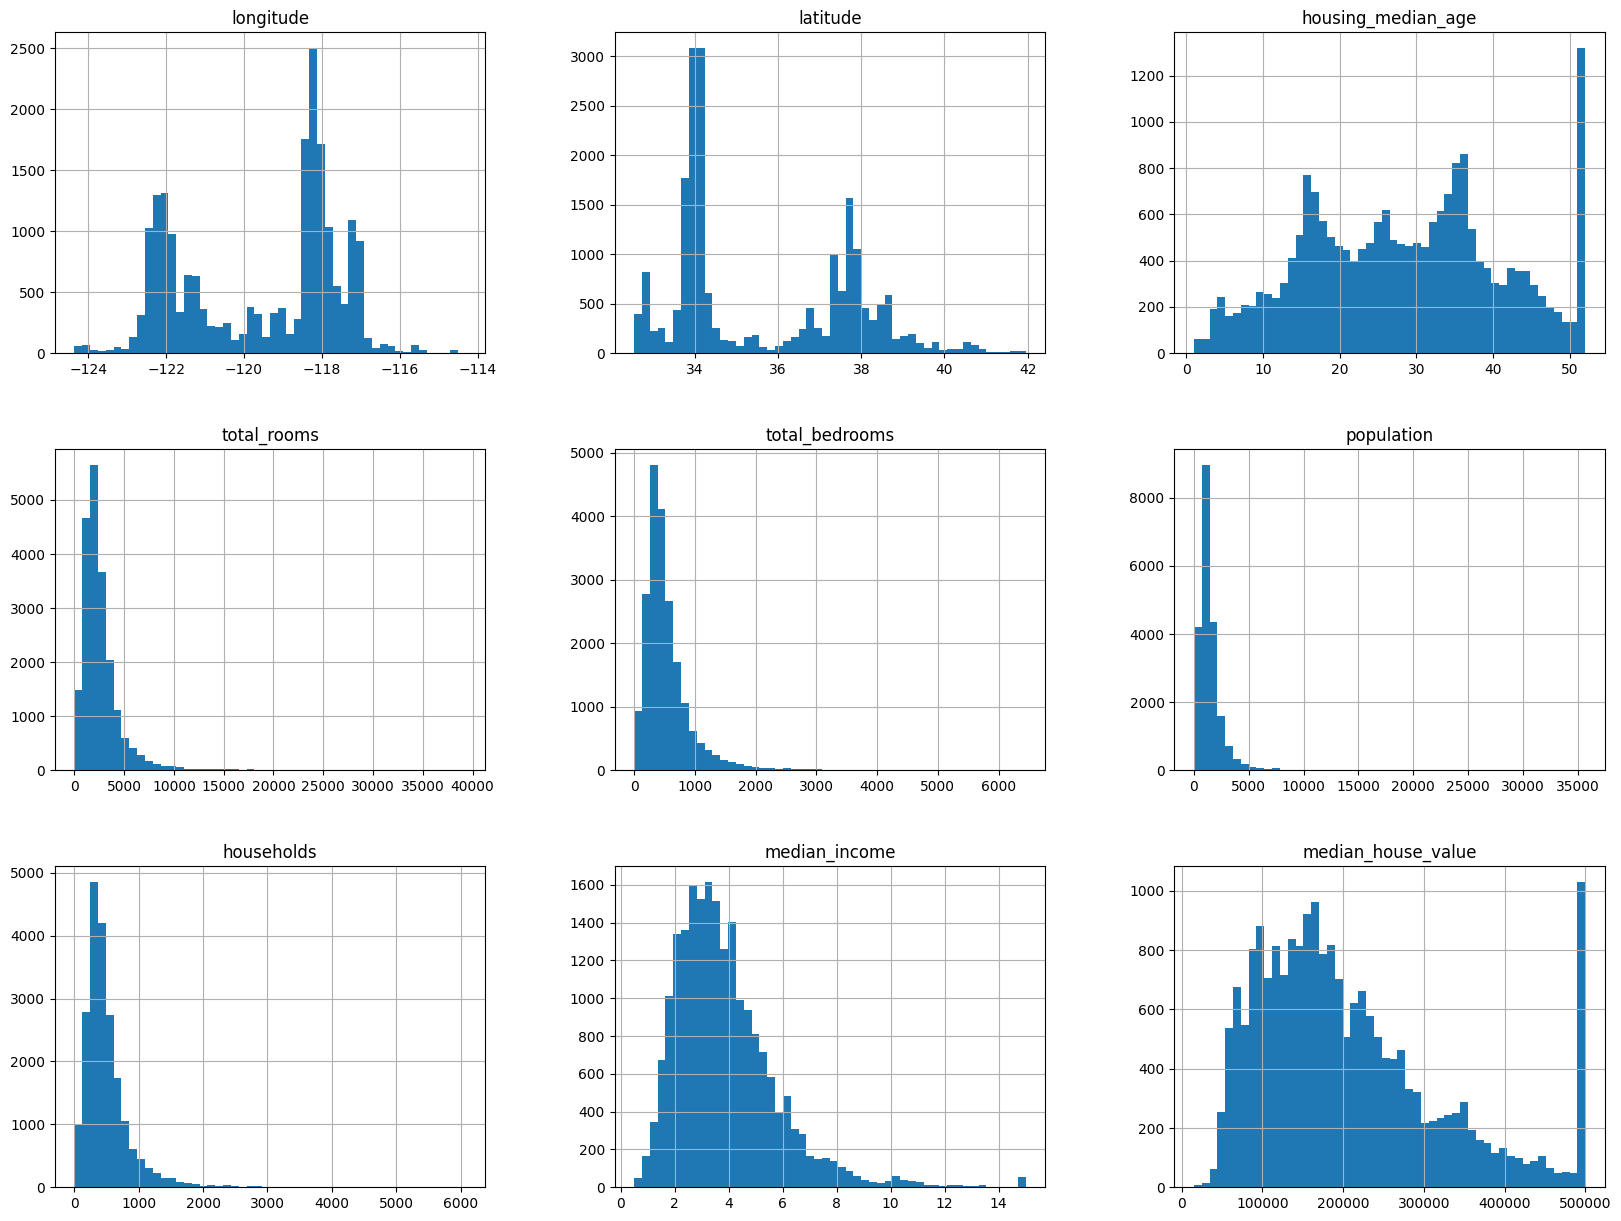

In [7]:
housing.hist(bins=50, figsize=(20,15))

# Discover and Visualize data to gain insights.

In [8]:
visuals_set = housing.copy() # make a copy of the training set for visualization reasons.

<Axes: xlabel='longitude', ylabel='latitude'>

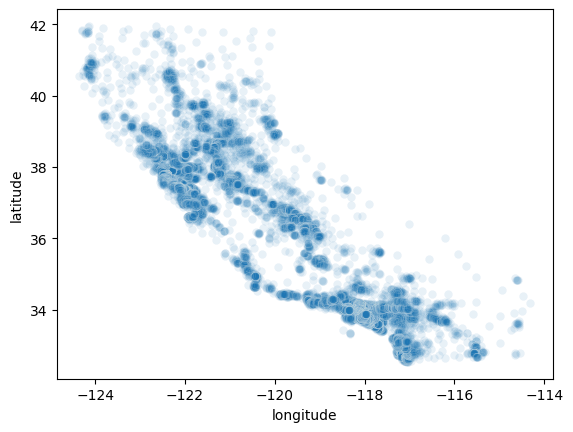

In [9]:
#@title Visualization-Geographical location
sns.scatterplot(visuals_set, x = 'longitude', y = 'latitude', alpha = 0.1) # the alpha is to easily show high density areas.


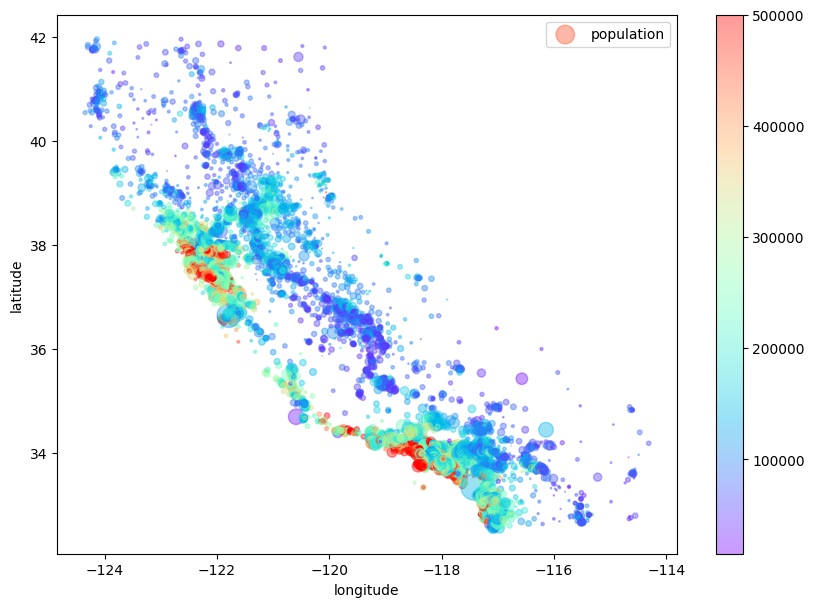

In [10]:
#@title Population and price
visuals_set.plot(kind='scatter',  x='longitude', y = 'latitude', alpha = 0.4,
                s=visuals_set['population']/100, label='population', figsize = (10, 7),
                c=visuals_set['median_house_value'], cmap=plt.get_cmap('rainbow'), colorbar=True)
plt.legend()

In [11]:
# check for correlation
corr_data = housing.copy()
corr_data.drop('ocean_proximity', axis = 1, inplace = True)
corr_matrix = corr_data.corr()

In [12]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<Axes: >

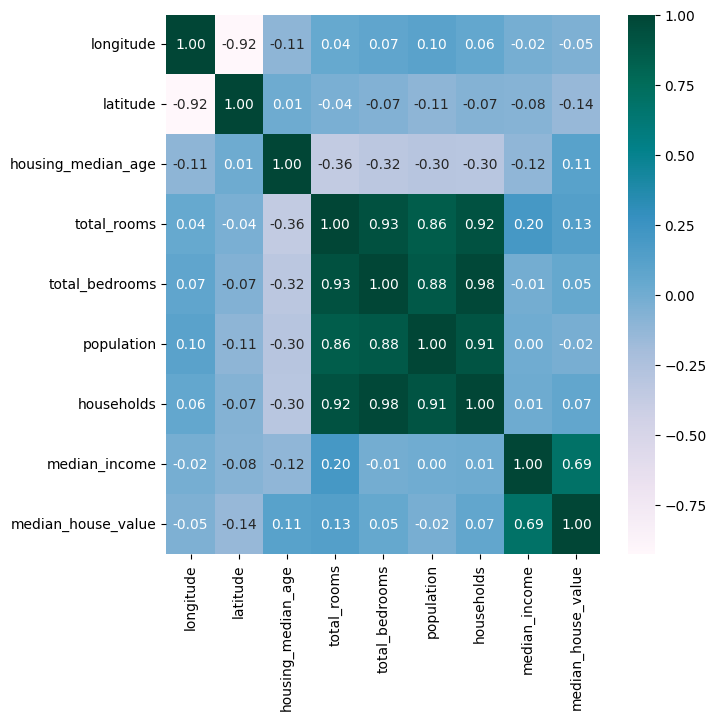

In [13]:
figure = plt.subplots(figsize = (7, 7))
sns.heatmap(data = corr_matrix, annot=True, cmap = "PuBuGn", fmt=".2f")

<Axes: xlabel='median_income', ylabel='median_house_value'>

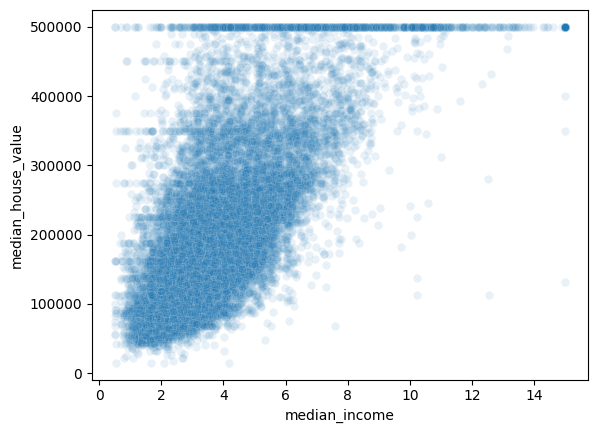

In [14]:
# investigate the linear relationship between median_income and median_house_value
sns.scatterplot(visuals_set, x='median_income', y='median_house_value', alpha = 0.1)

In [15]:
del corr_data, corr_matrix, visuals_set # remove no longer needed copies of the data

# Feature Engineering
# 1. Feature extraction

Get the average:
* Population per household
* Number of bedrooms per room
* rooms per household.

In [16]:
housing['persons_per_household'] = housing['population'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,persons_per_household,bedrooms_per_room,rooms_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,2.555556,0.146591,6.984127
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2.109842,0.155797,6.238137
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2.802260,0.129516,8.288136
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,2.547945,0.184458,5.817352
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2.181467,0.172096,6.281853


In [17]:
# recheck the correlation
corr_data = housing.copy()
corr_data.drop('ocean_proximity', axis = 1, inplace = True)
corr_data.corr()['median_house_value'].sort_values(ascending = False)

median_house_value       1.000000
median_income            0.688075
rooms_per_house          0.151948
total_rooms              0.134153
housing_median_age       0.105623
households               0.065843
total_bedrooms           0.049686
persons_per_household   -0.023737
population              -0.024650
longitude               -0.045967
latitude                -0.144160
bedrooms_per_room       -0.255880
Name: median_house_value, dtype: float64

# Stratified Sampling
- Done using the `median_income` field to ensure that the training and test data is representative of different categories of incomes.
- Divided into five(5) categories.

<Axes: >

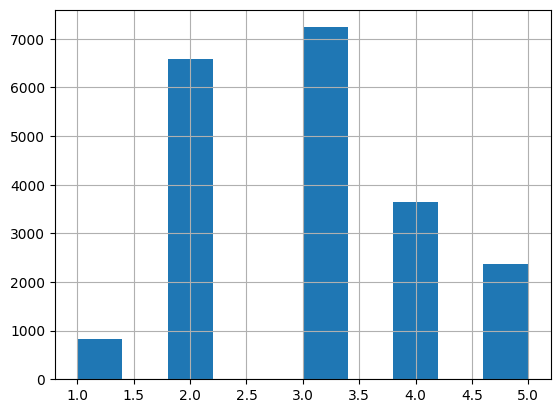

In [18]:
housing['income_category'] = pd.cut(housing['median_income'],
                                    bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

housing['income_category'].hist()

# Split the data into train and test split

The test split will be used to validate the model later on.


In [19]:
# train_set, test_set = train_test_split(housing, train_size=0.8, random_state=42)
# len(train_set), len(test_set)

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_category']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

# confirm the proportions
test_set['income_category'].value_counts() / len(test_set)

income_category
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
train_set['income_category'].value_counts()/len(train_set)

income_category
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [21]:
# drop the income category field to remain with the original data.
for data  in (train_set, test_set):
    data.drop('income_category', axis = 1, inplace = True)

# Preparing the data for Machine Learning.

### 1. Data Cleaning

In [22]:
X, y = train_set.drop('median_house_value', axis = 1), train_set['median_house_value']

In [23]:
# missing values
X.isnull().sum()

longitude                  0
latitude                   0
housing_median_age         0
total_rooms                0
total_bedrooms           158
population                 0
households                 0
median_income              0
ocean_proximity            0
persons_per_household      0
bedrooms_per_room        158
rooms_per_house            0
dtype: int64

In [24]:
imputer = SimpleImputer(strategy='median')
X_num = X.drop('ocean_proximity', axis = 1)
X_tr = imputer.fit_transform(X_num)

In [25]:

X_tr= pd.DataFrame(X_tr, columns=X_num.columns)
X_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,persons_per_household,bedrooms_per_room,rooms_per_house
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,3.168555,0.205784,5.485836
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,2.623698,0.160714,6.927083
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2.223333,0.191595,5.393333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,1.859213,0.276505,3.886128
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,3.167241,0.182692,6.096552


In [46]:
X_tr.isnull().sum()

longitude                0
latitude                 0
housing_median_age       0
total_rooms              0
total_bedrooms           0
population               0
households               0
median_income            0
persons_per_household    0
bedrooms_per_room        0
rooms_per_house          0
dtype: int64

### 2. Handling the categorical Variable

In [26]:
X_cat = train_set[['ocean_proximity']]
X_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


####  Ordinal Encoding

In [27]:
ordinal_encoder = OrdinalEncoder()
X_cat_encoded = ordinal_encoder.fit_transform(X_cat)

In [28]:
# categories
#ordinal_encoder.categories_

#### One-hot Encoding

In [29]:
cat_encoder = OneHotEncoder()
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [30]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 3. Pipelines

In [31]:
# Clean the data and standardize numerical data.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_num_tr = num_pipeline.fit_transform(X_num)
X_num_tr = pd.DataFrame(X_num_tr, columns=X_num.columns)

In [32]:
X_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,persons_per_household,bedrooms_per_room,rooms_per_house
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.006223,-0.122484,0.017395
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,-0.040811,-0.911663,0.569256
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.075371,-0.370939,-0.018024
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.106803,1.115873,-0.595140
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.006109,-0.526821,0.251241


#### Pipeline for both categorical and numerical columns

In [33]:
num_cols = list(X_num)
cat_cols = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), cat_cols),
])

X_train = full_pipeline.fit_transform(X)

In [34]:
X_train

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]], shape=(16512, 16))

# Select and train a model

In [35]:
model = LinearRegression()
model.fit(X_train, y)

LinearRegression()

In [36]:
# predict some random data
dummy_data = X.iloc[:10]
dummy_labels = y.iloc[:10]

dummy_prepared = full_pipeline.transform(dummy_data)
predictions = model.predict(dummy_prepared)

print("Labels: ", list(dummy_labels))
print("Predictions: ", predictions)

Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0]
Predictions:  [ 83648.54287152 305815.0882093  150013.37994426 188096.42566946
 241840.13952577 204937.6269467  378804.72742255 261249.73839994
 145552.20581991  54341.95853654]


In [37]:
predictions = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 68160.92435491859


In [38]:
# test the other algorithms
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'AdaBoost': AdaBoostRegressor(n_estimators=100 ),
    'GradientBoost': GradientBoostingRegressor(),
}

for name, model in models.items():
    model.fit(X_train, y)
    predictions = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    print(f"{name} RMSE: {rmse}")

DecisionTree RMSE: 0.0
RandomForest RMSE: 18583.048698685376
AdaBoost RMSE: 86087.06372459924
GradientBoost RMSE: 50440.05376745706


#  Evaluating the model using cross validation

In [39]:
# check the cross-validation score for decision tree

def cross_validation(algorithm): # function to perform cross validation
    scores = cross_val_score(algorithm, X_train, y, scoring='neg_mean_squared_error', cv=10)
    return np.sqrt(-scores)


def display_scores(scores): # function to display the scores.
    print("scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

# scores for Decision Tree
tree_scores = cross_validation(DecisionTreeRegressor())
display_scores(tree_scores)


scores:  [74512.26756851 70271.32300219 67712.22742596 70859.67314131
 69063.24359183 76283.66968272 71113.40769425 73589.4078508
 70358.23839664 70349.72671399]
Mean:  71411.31850682103
Standard Deviation:  2474.3706866775833


In [40]:
# linear regression scores
linear_reg_rmse_scores = cross_validation(LinearRegression())
display_scores(linear_reg_rmse_scores)

scores:  [71181.95098096 63825.56512744 67741.07241029 68256.29685279
 66711.2271161  72240.73664717 69981.07976999 68438.51358706
 65946.92067317 70073.85093767]
Mean:  68439.7214102642
Standard Deviation:  2408.8928462974714


In [41]:
# scores for RandomForest
# rf_model = cross_validation(RandomForestRegressor(n_estimators=1000, n-n_jobs=-1))
# display_scores(rf_model)

# scores:  [50532.82958301 48889.88399707 45808.83219353 50246.5452695
#  47126.71103233 48977.19104403 51299.04006817 48661.05717117
#  47269.50723812 52942.01887689]
# Mean:  49175.36164738053
# Standard Deviation:  2030.6629305401948

In [42]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train, y)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [43]:
# save the model
joblib.dump(model, 'housing_model1.pkl')

['housing_model1.pkl']

Overfit is still evident in the  model. 

# FINE TUNING THE MODEL

In [44]:
#  using grid search view to get the best parameters for the task
param_grid = [
    {'n_estimators': [3,10, 1000], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 1000]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 1000}

In [47]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64447.198273965114 {'max_features': 2, 'n_estimators': 3}
55226.11734920735 {'max_features': 2, 'n_estimators': 10}
51316.3482496557 {'max_features': 2, 'n_estimators': 1000}
59886.07888727066 {'max_features': 4, 'n_estimators': 3}
53254.336203151826 {'max_features': 4, 'n_estimators': 10}
49218.05246884956 {'max_features': 4, 'n_estimators': 1000}
59487.62610536435 {'max_features': 6, 'n_estimators': 3}
52492.55683218006 {'max_features': 6, 'n_estimators': 10}
48896.017724074685 {'max_features': 6, 'n_estimators': 1000}
58681.19214869893 {'max_features': 8, 'n_estimators': 3}
52312.903131390485 {'max_features': 8, 'n_estimators': 10}
49048.944198204044 {'max_features': 8, 'n_estimators': 1000}
62605.42646772091 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53735.20611323218 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59442.24171309755 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52193.77475185585 {'bootstrap': False, 'max_features': 3, 'n_est

In [48]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.68386808e-02, 6.84521181e-02, 4.25030332e-02, 1.77407913e-02,
       1.67620749e-02, 1.77118483e-02, 1.62116203e-02, 3.25912682e-01,
       1.08236057e-01, 8.26620663e-02, 5.69389794e-02, 1.18662392e-02,
       1.49069263e-01, 8.81673343e-05, 3.74474851e-03, 5.26163083e-03])

In [49]:
extra_attirbutes = ['rooms_per_house', 'bedrooms_per_room', 'persons_per_household']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_cols + extra_attirbutes + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3259126816034315), 'median_income'),
 (np.float64(0.14906926306614657), 'bedrooms_per_room'),
 (np.float64(0.10823605682659619), 'persons_per_household'),
 (np.float64(0.0826620663177009), 'bedrooms_per_room'),
 (np.float64(0.07683868080539145), 'longitude'),
 (np.float64(0.06845211807266763), 'latitude'),
 (np.float64(0.05693897941820293), 'rooms_per_house'),
 (np.float64(0.04250303322689609), 'housing_median_age'),
 (np.float64(0.017740791302076432), 'total_rooms'),
 (np.float64(0.017711848320913635), 'population'),
 (np.float64(0.016762074867524613), 'total_bedrooms'),
 (np.float64(0.01621162031804947), 'households'),
 (np.float64(0.011866239185954182), 'rooms_per_house'),
 (np.float64(0.005261630826368703), 'INLAND'),
 (np.float64(0.0037447485077384524), '<1H OCEAN'),
 (np.float64(8.816733434129354e-05), 'persons_per_household')]

# Evaluating the model on the test set

In [50]:
final_model = grid_search.best_estimator_

X_test = test_set.drop('median_house_value', axis = 1)
y_test = test_set['median_house_value']

X_test_prepared  = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

np.float64(46696.42125184832)

In [51]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44734.35671052, 48579.30470021])